In [1198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

https://www.programcreek.com/python/example/86074/sklearn.ensemble.RandomForestRegressor

In [1199]:
df = pd.read_csv('./data/total_0509.csv')

In [1200]:
cols = list(df.columns)
cols.remove('Date')

In [1201]:
df[cols] = df[cols].astype(int)

In [1202]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [1203]:
tmp_cols = ['EURO_conf','CHINA_conf','ASIA_conf','N_AMERICA_conf','OCEANIA_conf','TARGET']

In [1204]:
for i in tmp_cols:
    df['{}'.format(i)] = df['{}'.format(i)].diff()

In [1205]:
df.fillna(0, inplace=True)

In [1206]:
df.Date = pd.to_datetime(df.Date)
df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [1208]:
df.rename(columns={'TARGET':'target'},inplace=True)

In [1209]:
plt.style.use('ggplot')

In [1210]:
#df.plot(subplots=True, figsize=(10,20))

## lag 변수 생성

In [1211]:
lag_amount =3

for i in range(1,lag_amount+1):
    df['lag{}'.format(i)] = df['target'].shift(-i)
    #df['lag{}'.format(-i)] = df['target'].shift(-i)
    
df.dropna(inplace=True)

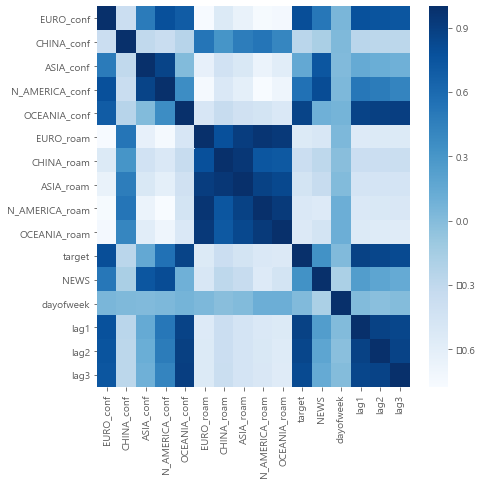

In [1212]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), cmap='Blues')

In [1213]:
df.tail()

,EURO_conf,CHINA_conf,ASIA_conf,N_AMERICA_conf,OCEANIA_conf,EURO_roam,CHINA_roam,ASIA_roam,N_AMERICA_roam,OCEANIA_roam,target,NEWS,dayofweek,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,
2020-04-28,11645.0,22.0,3456.0,25919.0,25.0,15,143,224,119,0,12.0,1763,1,5.0,4.0,8.0
2020-04-29,7438.0,4.0,4232.0,29042.0,10.0,24,118,333,102,6,5.0,1117,2,4.0,8.0,8.0
2020-04-30,10656.0,12.0,4674.0,31107.0,17.0,62,152,221,124,3,4.0,1266,3,8.0,8.0,10.0
2020-05-01,9243.0,3.0,5645.0,35923.0,18.0,24,230,247,126,27,8.0,1104,4,8.0,10.0,8.0
2020-05-02,11965.0,0.0,5006.0,30661.0,23.0,77,90,254,174,71,8.0,732,5,10.0,8.0,3.0


In [1214]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('target')
# train / test split 범위 지정
test_data_size = 21

# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

# X 변수 Scale 적용
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [1215]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

# 1. Random Forest

### 2-1. 모델생성

#### 2-1-1) 기본 옵션으로 모델 생성

In [1216]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf_uncustomized.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(rf_uncustomized.score(X_test,y_test)))

Score on training set : 0.969
Score on test set : -0.650


#### 2-1-2) 현재 생성된 트리 모델의 옵션 확인

In [1217]:
rf_uncustomized

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### 2-2. 모델 Parameter 조정

#### 2-2-1) n_estimator : 트리 수 변경에 따른 모델 성능

In [1218]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,30)]

for v_n_estimators in para_n_tree :
    rf = RandomForestRegressor(n_estimators= v_n_estimators)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test,y_test))

# 결과 저장

df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score
df_score_n['Gap'] = df_score_n['TrainScore'] - df_score_n['TestScore']

In [1219]:
# 모델 설명력 확인
df_score_n.round(3).sort_values(by='Gap').head()

,n_estimators,TrainScore,TestScore,Gap
1,20,0.972,0.050,0.922
5,60,0.969,0.010,0.959
9,100,0.970,-0.094,1.064
3,40,0.975,-0.133,1.108
26,270,0.973,-0.213,1.186


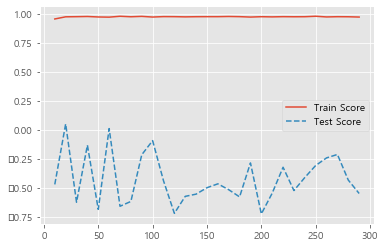

In [1220]:
# 모델 설명력 그래프 확인

plt.plot(para_n_tree, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

#### 2-2-2) min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [1221]:
train_score = []; test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf :
    rf = RandomForestRegressor(n_estimators=20,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test,y_test))
    
# 결과 저장

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score
df_score_leaf['Gap'] = df_score_leaf['TrainScore'] - df_score_leaf['TestScore']

In [1225]:
# 모델 설명력 확인
df_score_leaf.round(3).sort_values(by='Gap').head()

,MinSamplesLeaf,TrainScore,TestScore,Gap
5,6,0.891,0.274,0.617
8,9,0.867,0.188,0.679
3,4,0.926,0.070,0.857
4,5,0.915,-0.044,0.959
1,2,0.955,-0.171,1.125


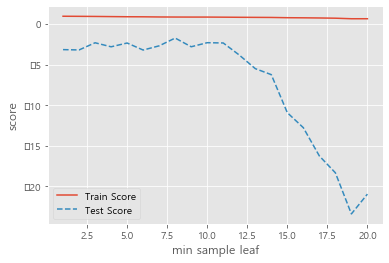

In [1163]:
# 모델 설명력 그래프 확인

plt.plot(para_leaf, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel("min sample leaf")
plt.legend()

#### 2-2-3) min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [1226]:
train_score = []; test_score = []

para_split = [n_split * 2 for n_split in range(2,41)]

for v_min_samples_split in para_split :
    rf = RandomForestRegressor(n_estimators=20,
                                 min_samples_leaf = 6,
                                min_samples_split = v_min_samples_split)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test, y_test))
    
# 결과 저장

df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
df_score_split['Gap'] = df_score_split['TrainScore'] - df_score_split['TestScore']

In [1227]:
# 모델 설명력 확인
df_score_split.round(3).sort_values(by='Gap').head()

,MinSamplesSplit,TrainScore,TestScore,Gap
27,58,-0.003,-0.012,0.008
28,60,-0.001,-0.038,0.037
31,66,-0.001,-0.046,0.045
36,76,-0.000,-0.057,0.057
38,80,-0.000,-0.080,0.080


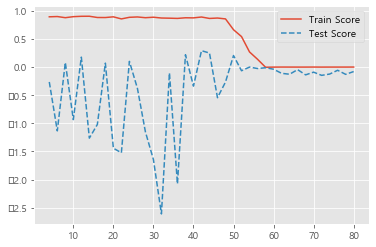

In [1228]:
# 모델 설명력 그래프 확인

plt.plot(para_split, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

## Feature Selection 1

In [1229]:
# 최종 파라미터 선정
rf = RandomForestRegressor(n_estimators=70)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=70, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [1230]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = X_cols
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(20)

,Feature,Importance
12,lag1,0.419
4,OCEANIA_conf,0.261
0,EURO_conf,0.107
13,lag2,0.052
14,lag3,0.052
2,ASIA_conf,0.018
1,CHINA_conf,0.017
3,N_AMERICA_conf,0.014
5,EURO_roam,0.013
7,ASIA_roam,0.013


In [1231]:
new_importance = df_importance[df_importance['Importance'] > 0.01]

Text(0, 0.5, '변수')

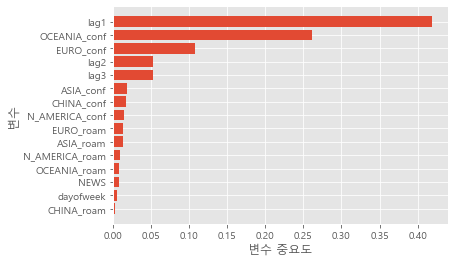

In [1232]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(15)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [1233]:
new_importance

,Feature,Importance
12,lag1,0.419043
4,OCEANIA_conf,0.261497
0,EURO_conf,0.106911
13,lag2,0.052035
14,lag3,0.052021
2,ASIA_conf,0.018497
1,CHINA_conf,0.017417
3,N_AMERICA_conf,0.014313
5,EURO_roam,0.013221
7,ASIA_roam,0.013195


150, 3 ,4

# 2. SVM Regressor

### 2-1. 모델생성

#### 2-1-1) 기본 옵션으로 모델 생성

In [1234]:
svm_uncustomized = SVR()
svm_uncustomized.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(svm_uncustomized.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(svm_uncustomized.score(X_test,y_test)))

Score on training set : 0.464
Score on test set : 0.189


#### 2-1-2) 현재 생성된 트리 모델의 옵션 확인

In [1235]:
svm_uncustomized

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### 2-2. 모델 Parameter 조정

#### 2-2-1) C 규제 변경

In [1236]:
train_score = []; test_score = []

para_C = [10 ** c for c in range(-2,3)] # 참조 para_c : [0.01,0.1,1,10,100]

for v_C in para_C :
    svm = SVR(C = v_C)
    svm.fit(X_train, y_train)
    train_score.append(svm.score(X_train, y_train))
    test_score.append(svm.score(X_test, y_test))
    
# 모델 설명력 저장

df_score_C = pd.DataFrame()
df_score_C['C'] = para_C
df_score_C['TrainScore'] = train_score
df_score_C['TestScore'] = test_score
df_score_C['Gap'] = df_score_C['TrainScore'] - df_score_C['TestScore']

In [1237]:
# 모델 설명력 확인
df_score_C.round(3).sort_values(by='Gap').head()

,C,TrainScore,TestScore,Gap
2,1.00,0.464,0.189,0.276
1,0.10,-0.180,-1.435,1.254
4,100.00,0.971,-0.524,1.495
3,10.00,0.872,-0.655,1.527
0,0.01,-0.301,-2.115,1.814


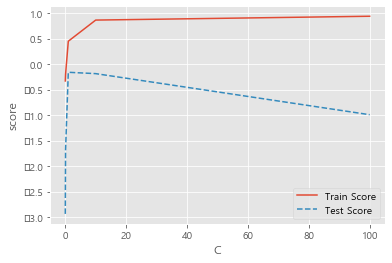

In [1175]:
# 모델 설명력 그래프 확인

plt.plot(para_C, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_C, test_score, linestyle = '--', label = 'Test Score')

plt.ylabel("score"); plt.xlabel('C')
plt.legend()

In [1238]:
train_score = []; test_score = []

para_gamma = [10 ** gamma for gamma in range(-2,3)]

for v_gamma in para_gamma :
    svm = SVR(gamma=v_gamma,
              C = 1)
    svm.fit(X_train, y_train)
    train_score.append(svm.score(X_train, y_train))
    test_score.append(svm.score(X_test,y_test))
    
# 결과 저장

df_score_gamma = pd.DataFrame()
df_score_gamma['gamma'] = para_gamma
df_score_gamma['TrainScore'] = train_score
df_score_gamma['TestScore'] = test_score
df_score_gamma['Gap'] = df_score_gamma['TrainScore'] - df_score_gamma['TestScore']

In [1239]:
df_score_gamma.round(3).sort_values(by='Gap').head()

,gamma,TrainScore,TestScore,Gap
1,0.10,0.353,0.118,0.235
0,0.01,0.268,-0.041,0.309
2,1.00,-0.189,-1.759,1.569
3,10.00,-0.240,-2.127,1.887
4,100.00,-0.239,-2.126,1.887


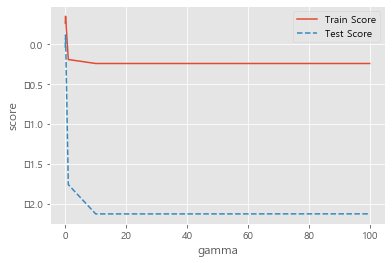

In [1240]:
# 모델 설명력 그래프 확인

plt.plot(para_gamma, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_gamma, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel("gamma")
plt.legend()

#### 2-2-2) epsilon 변경

In [1241]:
train_score = []; test_score = []

para_epsilon = [eps/20 for eps in range(1,21)]

for v_epsilon in para_epsilon :
    svm = SVR(epsilon=v_epsilon,
              C = 1,
             gamma = 0.1)
    svm.fit(X_train, y_train)
    train_score.append(svm.score(X_train, y_train))
    test_score.append(svm.score(X_test,y_test))
    
# 결과 저장

df_score_epsilon = pd.DataFrame()
df_score_epsilon['epsilon'] = para_epsilon
df_score_epsilon['TrainScore'] = train_score
df_score_epsilon['TestScore'] = test_score
df_score_epsilon['Gap'] = df_score_epsilon['TrainScore'] - df_score_epsilon['TestScore']

In [1242]:
# 모델 설명력 확인
df_score_epsilon.round(3).sort_values(by='Gap').head()

,epsilon,TrainScore,TestScore,Gap
9,0.50,0.367,0.134,0.233
11,0.60,0.371,0.137,0.233
10,0.55,0.369,0.136,0.233
13,0.70,0.375,0.140,0.234
12,0.65,0.373,0.139,0.234


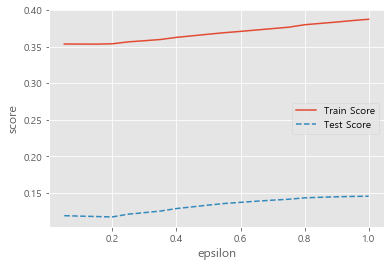

In [1243]:
# 모델 설명력 그래프 확인

plt.plot(para_epsilon, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_epsilon, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel("epsilon")
plt.legend()

## SVM model 생성

In [1244]:
svr_final = SVR(C = 1,
               gamma = 0.1,
               epsilon = 0.5)
svr_final.fit(X_train, y_train)

print('Score on training set : {:.3f}'.format(svr_final.score(X_train, y_train)))
print("Score on test set : {:.3f}".format(svr_final.score(X_test, y_test)))

Score on training set : 0.367
Score on test set : 0.134


In [1118]:
svr_final

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.55, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1245]:
estimators = [('rf', RandomForestRegressor(n_estimators=20)),
              ('svr', SVR(C = 1,
               gamma = 0.1,
               epsilon = 0.5))]

In [1246]:
reg = StackingRegressor(estimators=estimators)

In [1247]:
reg.fit(X_train, y_train).score(X_test, y_test)

0.02753074897119112

# Stacking Model Prediction

In [1248]:
# build model
Stacking_Model = StackingRegressor(estimators=estimators)

labels = y_train
features = X_train

# Fit the RF model with features and labels.
st_reg=Stacking_Model.fit(features, labels)

In [1249]:
# 모델 실행 및 결과 확인
X_test_predict=pd.DataFrame(
    st_reg.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    st_reg.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
SR_predict = X_train_predict.append(X_test_predict)

In [1250]:
st_reg.predict(X_test)

array([16.2673242 , 14.04601598, 14.81331403, 17.90658298, 17.12182307,
       13.0293404 , 12.09832293, 16.35161468, 12.77376091, 12.48957852,
       12.45730925, 13.59995883, 10.2850486 , 13.48031277, 11.38698909,
       12.69465696, 12.2459117 , 10.58644941, 11.15888604,  9.52580136,
       12.49927505])

In [1251]:
SR_predict.set_index(pd.to_datetime(df.index, format='%Y%m%d'), inplace=True)

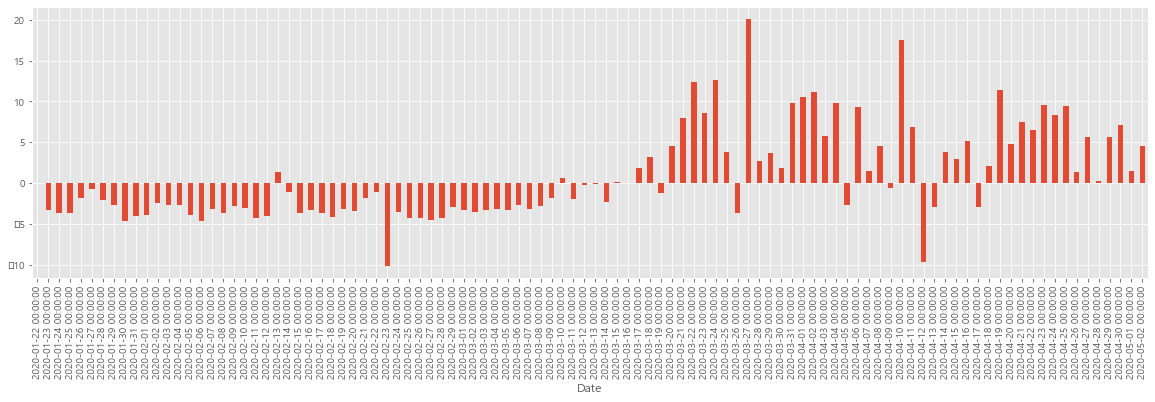

In [1252]:
plt.figure(figsize=(20,5))
SR_predict['diff']=SR_predict.predict - df.target
SR_predict['diff'].plot(kind='bar')

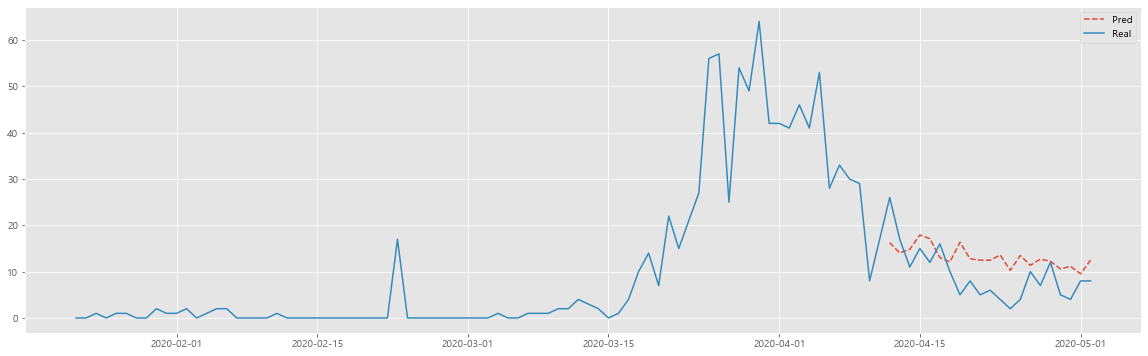

In [1253]:
plt.figure(figsize=(20,6))
plt.plot(SR_predict['predict'][-len(X_test):], '--',label='Pred', )
plt.plot(df['target'], label='Real')

plt.legend()

In [1254]:
st_reg.predict(X_test)

array([16.2673242 , 14.04601598, 14.81331403, 17.90658298, 17.12182307,
       13.0293404 , 12.09832293, 16.35161468, 12.77376091, 12.48957852,
       12.45730925, 13.59995883, 10.2850486 , 13.48031277, 11.38698909,
       12.69465696, 12.2459117 , 10.58644941, 11.15888604,  9.52580136,
       12.49927505])

In [1255]:
from sklearn.metrics import r2_score
RSquared = r2_score(y_train, X_train_predict.values)

In [1256]:
RSquared

0.9007159547771588

In [1257]:
st_reg.predict(X_test)

array([16.2673242 , 14.04601598, 14.81331403, 17.90658298, 17.12182307,
       13.0293404 , 12.09832293, 16.35161468, 12.77376091, 12.48957852,
       12.45730925, 13.59995883, 10.2850486 , 13.48031277, 11.38698909,
       12.69465696, 12.2459117 , 10.58644941, 11.15888604,  9.52580136,
       12.49927505])

In [1258]:
preds = pd.DataFrame({'real':y_test,'pred':st_reg.predict(X_test)})

In [1259]:
preds['gap'] = preds.real - preds.pred

In [1260]:
preds

,real,pred,gap
Date,,,
2020-04-12,26.0,16.267324,9.732676
2020-04-13,17.0,14.046016,2.953984
2020-04-14,11.0,14.813314,-3.813314
2020-04-15,15.0,17.906583,-2.906583
2020-04-16,12.0,17.121823,-5.121823
2020-04-17,16.0,13.029340,2.970660
2020-04-18,10.0,12.098323,-2.098323
2020-04-19,5.0,16.351615,-11.351615
2020-04-20,8.0,12.773761,-4.773761


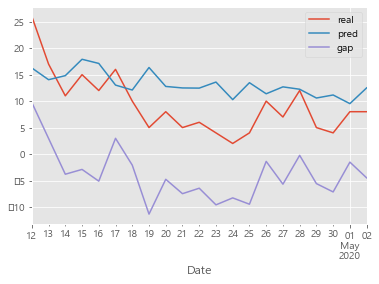

In [1261]:
preds.plot()

In [1262]:
from sklearn.metrics import mean_squared_error
# validation score
MSE = mean_squared_error(y_test, st_reg.predict(X_test))
RMSE = np.sqrt(MSE)
score = 100*(1-(((st_reg.predict(X_test) - y_test)**2).sum())/(st_reg.predict(X_test)**2).sum())

In [1263]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 38.35526319384901, RMSE : 6.193162616454456, SCORE : 78.51997162948872
